In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression as LR
from sklearn.decomposition import PCA
from scipy.stats import special_ortho_group as sog

from dca.cov_util import calc_cross_cov_mats_from_data
from dca.data_util import CrossValidate, form_lag_matrix
from dca.methods_comparison import SlowFeatureAnalysis as SFA
from dca import DynamicalComponentsAnalysis

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [53]:
from matplotlib import pyplot as plt

In [2]:
def linear_decode_r2(X_train, Y_train, X_test, Y_test, decoding_window=1, offset=0):
    """Train a linear model on the training set and test on the test set.
    This will work with batched training data and/or batched test data.
    """

    if isinstance(X_train, np.ndarray) and X_train.ndim == 2:
        X_train = [X_train]
    if isinstance(Y_train, np.ndarray) and Y_train.ndim == 2:
        Y_train = [Y_train]

    if isinstance(X_test, np.ndarray) and X_test.ndim == 2:
        X_test = [X_test]
    if isinstance(Y_test, np.ndarray) and Y_test.ndim == 2:
        Y_test = [Y_test]

    X_train_lags = [form_lag_matrix(Xi, decoding_window) for Xi in X_train]
    X_test_lags = [form_lag_matrix(Xi, decoding_window) for Xi in X_test]

    Y_train = [Yi[decoding_window // 2:] for Yi in Y_train]
    Y_train = [Yi[:len(Xi)] for Yi, Xi in zip(Y_train, X_train_lags)]
    if offset >= 0:
        Y_train = [Yi[offset:] for Yi in Y_train]
    else:
        Y_train = [Yi[:Yi.shape[0] + offset] for Yi in Y_train]

    Y_test = [Yi[decoding_window // 2:] for Yi in Y_test]
    Y_test = [Yi[:len(Xi)] for Yi, Xi in zip(Y_test, X_test_lags)]
    if offset >= 0:
        Y_test = [Yi[offset:] for Yi in Y_test]
    else:
        Y_test = [Yi[:Yi.shape[0] + offset] for Yi in Y_test]

    if offset >= 0:
        X_train_lags = [Xi[:Xi.shape[0] - offset] for Xi in X_train_lags]
        X_test_lags = [Xi[:Xi.shape[0] - offset] for Xi in X_test_lags]
    else:
        X_train_lags = [Xi[-offset:] for Xi in X_train_lags]
        X_test_lags = [Xi[-offset:] for Xi in X_test_lags]

    if len(X_train_lags) == 1:
        X_train_lags = X_train_lags[0]
    else:
        X_train_lags = np.concatenate(X_train_lags)

    if len(Y_train) == 1:
        Y_train = Y_train[0]
    else:
        Y_train = np.concatenate(Y_train)

    if len(X_test_lags) == 1:
        X_test_lags = X_test_lags[0]
    else:
        X_test_lags = np.concatenate(X_test_lags)

    if len(Y_test) == 1:
        Y_test = Y_test[0]
    else:
        Y_test = np.concatenate(Y_test)

    model = LR().fit(X_train_lags, Y_train)
    r2 = model.score(X_test_lags, Y_test)
    return r2


In [3]:
X_train = np.random.rand(100, 10)
Y_train = np.random.rand(100, 10)

X_test = np.random.rand(100, 10)
Y_test = np.random.rand(100, 10)


In [4]:
linear_decode_r2(X_train, Y_train, X_test, Y_test)

-0.1058145442132264

# TODO:

1. Get DMD, DCA, and JPCA functions
2. Split conditions into training and test
3. Run through R^2 pipeline
4. Get pretty plots

In [5]:
from dca import DynamicalComponentsAnalysis
from dca.methods_comparison import JPCA
from pydmd import DMD

In [6]:
from scipy.io import loadmat

x = loadmat("../data/exampleData.mat")

In [48]:
X = x['Data']
X = X.flatten()
# leave a third for testing
def split_train_test(X):
    test_train_identifier = np.random.choice(2, 108, p=[.67, .33])

    conditions_train = []
    time_train = []

    conditions_test = []
    time_test = []

    for i in range(108):
        if test_train_identifier[i] == 0:
            conditions_train.append(X[i][0])
            time_test.append(X[i][1])
        else:
            conditions_test.append(X[i][0])
            time_test.append(X[i][1])
    return np.array(conditions_train), np.array(conditions_test)

In [49]:
conditions_train, conditions_test = split_train_test(X)
conditions_train.shape

(73, 61, 218)

In [29]:
def compare_methods_r2(X_train, Y_train, X_test, Y_test, d=2, decoding_window=1, offset=1):
    X_mean = np.concatenate(X_train).mean(axis=0, keepdims=True)
    X_train_ctd = np.array([Xi - X_mean for Xi in X_train])
    X_test_ctd = X_test - X_mean
    Y_mean = np.concatenate(Y_train).mean(axis=0, keepdims=True)
    Y_train_ctd = np.array([Yi - Y_mean for Yi in Y_train])
    Y_test_ctd = Y_test - Y_mean
    
    # Initiate methods
    jpca = JPCA(n_components=d)
    dca = DynamicalComponentsAnalysis(d=d, T=3)
    dmd = DMD(svd_rank=d)
    pca = PCA(n_components=d)
    
    # Run methods on training data
    pca.fit(np.vstack(X_train_ctd))
    jpca.fit(X_train_ctd)
    dca.fit(X_train_ctd)
    # dmd uses columns as features
    dmd.fit(np.vstack(X_train_ctd).T)
    
    # Transform data with fit models
    
    X_train_pca = [pca.transform(Xi) for Xi in X_train_ctd]
    X_test_pca = [pca.transform(Xi) for Xi in X_test_ctd]
    
    X_train_jpca = jpca.transform(X_train_ctd)
    X_test_jpca = jpca.transform(X_test_ctd)
    
    X_train_dca = dca.transform(X_train_ctd)
    X_test_dca = dca.transform(X_test_ctd)
    
    X_train_dmd = X_train_ctd @ dmd._modes
    X_test_dmd = X_test_ctd @ dmd._modes
    
    pca_score = linear_decode_r2(X_train_pca, Y_train_ctd, X_test_pca, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    jpca_score = linear_decode_r2(X_train_jpca, Y_train_ctd, X_test_jpca, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    dca_score = linear_decode_r2(X_train_dca, Y_train_ctd, X_test_dca, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    dmd_score = linear_decode_r2(X_train_dmd, Y_train_ctd, X_test_dmd, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    
    return pca_score, jpca_score, dca_score, dmd_score
    

In [50]:
compare_methods_r2(conditions_train, conditions_train, conditions_test, conditions_test, d=6, offset=1)

/home/rguo/work/churchland/dca/rguo/DynamicalComponentsAnalysis/dca/data_util.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  X_with_lags[i, :] = X[i * stride:i * stride + T, :].flatten()


(0.6928114382151387,
 0.27143950647804654,
 0.5364595342893868,
 0.4560290390810042)

In [51]:
offsets = [i*5 for i in range(1, 10)]
pca_scores = []
jpca_scores = []
dca_scores = []
dmd_scores = []

for offset in offsets:
    conditions_train, conditions_test = split_train_test(X)
    pca_score, jpca_score, dca_score, dmd_score = compare_methods_r2(conditions_train,
                                                                     conditions_train,
                                                                     conditions_test,
                                                                     conditions_test,
                                                                     offset=offset)
    pca_scores.append(pca_score)
    jpca_scores.append(jpca_score)
    dca_scores.append(dca_score)
    dmd_scores.append(dmd_score)

/home/rguo/work/churchland/dca/rguo/DynamicalComponentsAnalysis/dca/data_util.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  X_with_lags[i, :] = X[i * stride:i * stride + T, :].flatten()


/home/rguo/work/churchland/dca/rguo/DynamicalComponentsAnalysis/dca/data_util.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  X_with_lags[i, :] = X[i * stride:i * stride + T, :].flatten()


/home/rguo/work/churchland/dca/rguo/DynamicalComponentsAnalysis/dca/data_util.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  X_with_lags[i, :] = X[i * stride:i * stride + T, :].flatten()


/home/rguo/work/churchland/dca/rguo/DynamicalComponentsAnalysis/dca/data_util.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  X_with_lags[i, :] = X[i * stride:i * stride + T, :].flatten()


/home/rguo/work/churchland/dca/rguo/DynamicalComponentsAnalysis/dca/data_util.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  X_with_lags[i, :] = X[i * stride:i * stride + T, :].flatten()


/home/rguo/work/churchland/dca/rguo/DynamicalComponentsAnalysis/dca/data_util.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  X_with_lags[i, :] = X[i * stride:i * stride + T, :].flatten()


/home/rguo/work/churchland/dca/rguo/DynamicalComponentsAnalysis/dca/data_util.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  X_with_lags[i, :] = X[i * stride:i * stride + T, :].flatten()


/home/rguo/work/churchland/dca/rguo/DynamicalComponentsAnalysis/dca/data_util.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  X_with_lags[i, :] = X[i * stride:i * stride + T, :].flatten()


/home/rguo/work/churchland/dca/rguo/DynamicalComponentsAnalysis/dca/data_util.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  X_with_lags[i, :] = X[i * stride:i * stride + T, :].flatten()


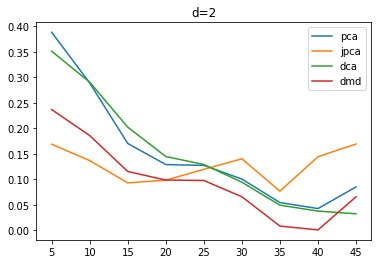

In [56]:
plt.plot(offsets, pca_scores, label="pca")
plt.plot(offsets, jpca_scores, label="jpca")
plt.plot(offsets, dca_scores, label="dca")
plt.plot(offsets, dmd_scores, label="dmd")
plt.title("d=2")
plt.legend()
plt.show()

In [58]:
%%capture --no-display

offsets = [i*5 for i in range(1, 10)]
pca_scores = []
jpca_scores = []
dca_scores = []
dmd_scores = []

for offset in offsets:
    conditions_train, conditions_test = split_train_test(X)
    pca_score, jpca_score, dca_score, dmd_score = compare_methods_r2(conditions_train,
                                                                     conditions_train,
                                                                     conditions_test,
                                                                     conditions_test,
                                                                     d=6,
                                                                     offset=offset)
    pca_scores.append(pca_score)
    jpca_scores.append(jpca_score)
    dca_scores.append(dca_score)
    dmd_scores.append(dmd_score)

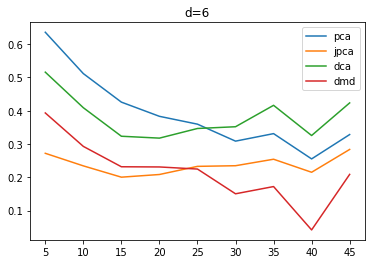

In [59]:
plt.plot(offsets, pca_scores, label="pca")
plt.plot(offsets, jpca_scores, label="jpca")
plt.plot(offsets, dca_scores, label="dca")
plt.plot(offsets, dmd_scores, label="dmd")
plt.title("d=6")
plt.legend()
plt.show()

In [60]:
%%capture --no-display

offsets = [i*5 for i in range(1, 10)]
pca_scores = []
jpca_scores = []
dca_scores = []
dmd_scores = []

for offset in offsets:
    conditions_train, conditions_test = split_train_test(X)
    pca_score, jpca_score, dca_score, dmd_score = compare_methods_r2(conditions_train,
                                                                     conditions_train,
                                                                     conditions_test,
                                                                     conditions_test,
                                                                     d=20,
                                                                     offset=offset)
    pca_scores.append(pca_score)
    jpca_scores.append(jpca_score)
    dca_scores.append(dca_score)
    dmd_scores.append(dmd_score)

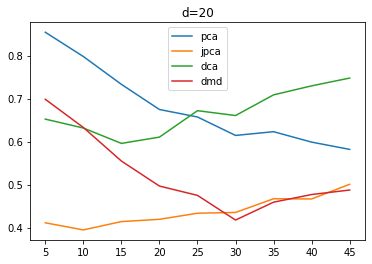

In [61]:
plt.plot(offsets, pca_scores, label="pca")
plt.plot(offsets, jpca_scores, label="jpca")
plt.plot(offsets, dca_scores, label="dca")
plt.plot(offsets, dmd_scores, label="dmd")
plt.title("d=20")
plt.legend()
plt.show()

# Other methods to compare against
DCA -> JPCA
DMD -> JPCA